<a href="https://colab.research.google.com/github/Rafijuliasgeoinfo/stem-lean-uav-lidar/blob/main/STEM_LEAN_LIDAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
##### LiDAR BASED STEM LEAN MEASUREMENT SCRIPT (BY HUSNA RAFI JULIAS)

from google.colab import drive

# Lepas kalau sebelumnya pernah ter-mount
drive.flush_and_unmount()
!fusermount -u /content/drive || true

# Bersihkan folder mountpoint lalu buat ulang
!rm -rf /content/drive
!mkdir -p /content/drive

# Mount lagi
drive.mount('/content/drive', force_remount=True)




fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


In [24]:
# ####### Three methods for measuring stem lean============================================================
# TREE LEAN v1 — (1) TRUNK, (2) EXTREME (top/mid/auto + QC), (3) B→T
# ============================================================

# --- Install (Colab)
!pip -q install --upgrade pip
!pip -q install numpy pandas shapely geopandas pyogrio rasterio tqdm matplotlib scipy

# --- Imports
import os, glob, math, warnings, re
import numpy as np, pandas as pd
from tqdm import tqdm
from scipy.spatial import cKDTree
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.ticker import ScalarFormatter
from rasterio.transform import from_origin

warnings.filterwarnings("ignore")
gpd.options.io_engine = "pyogrio"

# =======================
# INPUT
# =======================
MODE = "A_single_csv"                 # "A_single_csv" atau "B_folder_csv"
CSV_PATH = "/content/drive/MyDrive/Stemlean/Input/Exemple_tree.csv"    # jika MODE="A_single_csv"
CSV_DIR  = "/content/drive/MyDrive/Stemlean/data/per_tree_csv"  # jika MODE="B_folder_csv"
CRS_EPSG = 32749                      # SESUAIKAN

# =======================
# PARAMETER (robust)
# =======================
FORCE_ONE_PER_TREE   = True       # paksa tiap metode mengeluarkan panah (pakai fallback)
FORCE_RECOMPUTE_HAG  = True       # recompute HAG dari Z meski kolom sudah ada (lebih aman)

# --- Ground guard (abaikan titik terlalu dekat tanah) ---
GROUND_HAG_MIN       = 0.06       # m; titik < ini tidak dipakai untuk "bagian bawah"

# --- util utk samakan panjang daftar adaptif ---
def _normalize_steps(*lists):
    L = max(len(x) for x in lists if isinstance(x, (list, tuple)))
    out=[]
    for Lst in lists:
        if not isinstance(Lst, (list, tuple)):
            out.append([Lst]*L)
        else:
            out.append(list(Lst) + [Lst[-1]]*(L-len(Lst)) if len(Lst)<L else list(Lst))
    return out

# --- TRUNK robust ---
TRUNK_EXPAND_BANDS = [0.12, 0.20, 0.35, 0.50]
TRUNK_MINPOINTS    = [80, 60, 40, 25]
TRUNK_MININLIERS   = [60, 45, 30, 20]
TRUNK_EXPAND_BANDS, TRUNK_MINPOINTS, TRUNK_MININLIERS = _normalize_steps(TRUNK_EXPAND_BANDS, TRUNK_MINPOINTS, TRUNK_MININLIERS)

CORE_KNN, CORE_SCALE, CORE_R_MINMAX = 12, 1.5, (0.06, 0.60)
RANSAC_MAX_ITERS, RANSAC_T_MULT = 600, 2.0
BIN_DZ, R_PROFILE_Q, R_PROFILE_PAD, TAPER_MAX_SLOPE = 0.40, 0.80, 1.10, 0.04
EIGEN_RATIO_MIN, MIN_AXIS_LEN, MAX_LEAN_FLAG = 4.0, 1.3, 75.0

# --- EXTREME (bawah→atas atau bawah→tengah) + QC ---
EXT_MODE        = "auto"          # "top" | "mid" | "auto"
EXT_PRIORITY    = "top_first"     # jika auto: "mid_first" atau "top_first"

EXT_BOT_STEPS   = [0.01, 0.03, 0.05, 0.10]         # HN ≤ q_low
EXT_TOP_STEPS   = [0.25, 0.30, 0.35, 0.45]         # HN ≥ 1 - q_top
EXT_MID_STEPS   = [(0.35,0.65),(0.30,0.70),(0.25,0.75),(0.20,0.80)]  # [lo,hi]
EXT_MINPTS      = [5, 4, 3, 3]                      # min titik bawah & atas/tengah

# QC EXTREME: wajib ada beda tinggi & komponen vertikal
EXT_MIN_DZ_ABS   = 0.40    # m; beda tinggi minimal (median top - median bottom)
EXT_MIN_DZ_FRAC  = 0.15    # fraksi tinggi pohon (H99−H01) sebagai syarat alternatif
EXT_MIN_VZ_FRAC  = 0.12    # |vz| minimal (≈ lean <= ~83°). Jika di bawah → anggap tidak valid

# filter radial opsional untuk band tengah
EXT_MID_RAD_MULT     = 2.2    # None = nonaktif; angka → aktif
EXT_MID_USE_PCA_AXIS = True   # referensi sumbu PCA global

EXT_BOT_STEPS, EXT_TOP_STEPS, EXT_MID_STEPS, EXT_MINPTS = _normalize_steps(
    EXT_BOT_STEPS, EXT_TOP_STEPS, EXT_MID_STEPS, EXT_MINPTS
)

# --- B→T trunk-line ---
BT_BOT_STEPS  = [(0.03,0.18),(0.03,0.25),(0.03,0.30)]
BT_MID_STEPS  = [(0.35,0.75),(0.30,0.80),(0.25,0.85)]
BT_MIN_MID    = [10, 7, 5]
BT_RAD_MULTS  = [2.2, 2.6, 3.0]
BT_BOT_STEPS, BT_MID_STEPS, BT_MIN_MID, BT_RAD_MULTS = _normalize_steps(
    BT_BOT_STEPS, BT_MID_STEPS, BT_MIN_MID, BT_RAD_MULTS
)

# --- Preview & raster
ARROW_LEN_M, ARROW_VIS_LEN = 2.0, 9.0
ARROW_LW, ARROW_HEAD_MS, ARROW_ALPHA = 2.5, 15, 1.0  # user override: linewidth, head size, alpha
BG_MAX_POINTS, PREVIEW_TREE_MAX = 120_000, 24
LEAN_BINS  = [0, 5, 20, 90]  # user override: class breaks (deg)
LEAN_LABEL = ["0–5°", "5–20°", ">20°"]  # user override: legend labels
CLASS_COLORS = ["#26a269", "#FFA500", "#c01c28"] # hijau, kuning, merah (jelas terlihat)
MAKE_RASTER, RASTER_RES, RASTER_NODATA = True, 5.0, -9999.0

OUT_DIR  = "/content/drive/MyDrive/Stemlean/Output"; os.makedirs(OUT_DIR, exist_ok=True)
PREV_DIR = os.path.join(OUT_DIR,"previews"); os.makedirs(PREV_DIR, exist_ok=True)
SHP_DIR  = os.path.join(OUT_DIR,"shp"); os.makedirs(SHP_DIR, exist_ok=True)
GPKG_PATH = os.path.join(OUT_DIR,"trees_lean.gpkg")

# =======================
# UTIL plotting
# =======================
def set_full_coord_ticks(ax):
    ax.ticklabel_format(axis='both', style='plain', useOffset=False)
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.get_yaxis().get_offset_text().set_visible(False)

def add_north_arrow(ax, loc="NE", length=0.10, head_ms=22, lw=2.4, gap_pt=10, label="N"):
    pad=0.03; top_margin_ax=0.003
    if   loc=="NE": x=1.0-pad
    elif loc=="NW": x=pad
    elif loc=="SE": x=1.0-pad
    else:           x=pad
    fig=ax.figure; bb=ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_h_in=max(bb.height,1e-6); gap_ax=(gap_pt/72.0)/ax_h_in
    y_tip=1.0-pad-top_margin_ax-gap_ax
    y0=min(max(pad+0.01, y_tip-0.12), y_tip-0.05)
    arr=FancyArrowPatch((x,y0),(x,y_tip),transform=ax.transAxes,arrowstyle="-|>",
                        mutation_scale=head_ms,linewidth=lw,color="k",zorder=6,clip_on=True)
    ax.add_patch(arr)
    ax.text(x, y_tip+gap_ax, label, transform=ax.transAxes, ha="center", va="bottom",
            fontsize=11, fontweight="bold", bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.75), zorder=7)

def add_arrow(ax, x0,y0,x1,y1,color):
    dx,dy=(x1-x0),(y1-y0); n=math.hypot(dx,dy)
    if n==0: return
    ux,uy=dx/n, dy/n
    xe,ye=x0+ARROW_VIS_LEN*ux, y0+ARROW_VIS_LEN*uy
    patch=FancyArrowPatch((x0,y0),(xe,ye),arrowstyle="-|>",mutation_scale=ARROW_HEAD_MS,
                          linewidth=ARROW_LW,color=color,alpha=ARROW_ALPHA,zorder=3)
    patch.set_path_effects([pe.Stroke(linewidth=ARROW_LW+1.4, foreground="k", alpha=0.28), pe.Normal()])
    ax.add_patch(patch)

# =======================
# UTIL geometri
# =======================
def rel_height(z): return z - np.nanpercentile(z, 1.0)

def pca_axis(xyz):
    X = xyz - xyz.mean(axis=0, keepdims=True)
    C = np.cov(X, rowvar=False)
    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    evals, evecs = evals[idx], evecs[:, idx]
    axis = evecs[:,0]
    if axis[2] < 0: axis = -axis
    ratio = (evals[0] / max(evals[1], 1e-9))
    return axis/np.linalg.norm(axis), evals, ratio

def axis_to_lean_azimuth(axis):
    vx,vy,vz=axis; nrm=np.linalg.norm(axis)
    if nrm==0: return None,None
    lean=math.degrees(math.acos(abs(vz)/nrm))
    az=(90.0 - math.degrees(math.atan2(vy,vx))) % 360.0
    return float(lean), float(az)

def estimate_r0_xy(x,y,k=12,scale=1.5,r_minmax=(0.06,0.60)):
    P=np.c_[x,y]
    if len(P)<k+1: return np.median(x), np.median(y), float(np.clip(0.12,*r_minmax))
    tree=cKDTree(P); d,_=tree.query(P,k=k+1)
    r0=np.median(d[:,-1])*scale
    return np.median(x), np.median(y), float(np.clip(r0,*r_minmax))

def line_ransac(xyz, r0, max_iters=600, min_inliers=60, t_mult=2.0, seed=42):
    rng=np.random.default_rng(seed)
    N=xyz.shape[0]; thr=max(0.05, t_mult*float(r0))
    best=(-1,None,None,None)
    for _ in range(max_iters):
        i,j=rng.integers(0,N,2);
        if i==j: continue
        P0=xyz[i]; v=xyz[j]-xyz[i]; nv=np.linalg.norm(v)
        if nv<1e-6: continue
        v/=nv; P=xyz-P0; t=P@v
        d=np.linalg.norm(P - t[:,None]*v[None,:], axis=1)
        inl=d<=thr; cnt=int(inl.sum())
        if cnt>best[0]:
            best=(cnt,inl,v,P0)
            if cnt>0.9*N: break
    if best[0]<min_inliers: raise ValueError("RANSAC inlier terlalu sedikit")
    axis,_,ratio=pca_axis(xyz[best[1]])
    if axis[2]<0: axis=-axis
    return axis,best[1],ratio,best[3]

def dist_to_axis(P,P0,v):
    P0P=P-P0; t=(P0P@v)
    return np.linalg.norm(P0P - t[:,None]*v[None,:], axis=1), t

def smooth_median(a,win=2):
    if len(a)<=1: return a
    out=a.copy()
    for i in range(len(a)):
        s=max(0,i-win); e=min(len(a),i+win+1)
        out[i]=np.median(a[s:e])
    return out

# =======================
import pandas as pd, numpy as np, re

CSV_COLS_ORDER = ["X","Y","Z","tree_id","HeightAboveGround"]

def _clean_col(c):
    c = str(c).strip()
    c = re.sub(r'^[\\/]+', '', c)   # buang leading // atau \/
    return c.replace(" ", "").lower()

def _guess(colnames, candidates):
    m = {_clean_col(c): c for c in colnames}
    for k in candidates:
        if k in m: return m[k]
    return None

def _postprocess(df):
    # pastikan numeric
    for c in ["X","Y","Z","HeightAboveGround"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df.dropna(subset=["X","Y","Z"], inplace=True)

    # tree_id ke int
    if "tree_id" not in df.columns:
        df["tree_id"] = 1
    else:
        df["tree_id"] = pd.to_numeric(df["tree_id"], errors="coerce").fillna(1).astype(int)

    # HAG jika kosong
    if "HeightAboveGround" not in df.columns or df["HeightAboveGround"].isna().all():
        df["HeightAboveGround"] = np.nan
        for tid, dfg in df.groupby("tree_id"):
            z = dfg["Z"].to_numpy()
            base = np.nanpercentile(z, 1.0)
            df.loc[dfg.index, "HeightAboveGround"] = z - base

    # HN 0–1
    df["HN"] = np.nan
    for tid, dfg in df.groupby("tree_id"):
        H = dfg["HeightAboveGround"].to_numpy()
        df.loc[dfg.index, "HN"] = (H - np.nanmin(H)) / max(np.nanmax(H)-np.nanmin(H), 1e-6)

    return df[["X","Y","Z","tree_id","HeightAboveGround","HN"]]

def load_points_csv_auto(path):
    # 1) Coba asumsikan TANPA HEADER (sesuai file kamu)
    df_try = pd.read_csv(
        path, header=None, names=CSV_COLS_ORDER,
        delim_whitespace=True, engine="c"
    )
    # Jika baris pertama tidak numerik (mis. header), X/Y/Z jadi NaN → deteksi header
    bad_head = df_try[["X","Y","Z"]].head(3).isna().all(axis=1).any()
    if not bad_head:
        return _postprocess(df_try)

    # 2) Fallback: ADA HEADER → map kolom yang relevan
    df = pd.read_csv(path, header=0, delim_whitespace=True, engine="c")
    x = _guess(df.columns, ["x","posx","easting","lon","x(m)"])
    y = _guess(df.columns, ["y","posy","northing","lat","y(m)"])
    z = _guess(df.columns, ["z","posz","height","elev","z(m)"])
    if x is None and "//x" in [_clean_col(c) for c in df.columns]:
        # cari kolom dengan nama seperti //X
        x = [c for c in df.columns if _clean_col(c)=="x"][0]
    if y is None and any(_clean_col(c)=="y" for c in df.columns):
        y = [c for c in df.columns if _clean_col(c)=="y"][0]
    if z is None and any(_clean_col(c)=="z" for c in df.columns):
        z = [c for c in df.columns if _clean_col(c)=="z"][0]

    tid = _guess(df.columns, ["tree_id","cloud","origonal","original","cluster","id","tree"])
    hag = _guess(df.columns, ["heightaboveground","hag"])

    need = {"X":x,"Y":y,"Z":z}
    if any(v is None for v in need.values()):
        raise ValueError("Tidak menemukan kolom X/Y/Z pada CSV dengan header.")

    use = {"X":x, "Y":y, "Z":z}
    if tid: use["tree_id"] = tid
    if hag: use["HeightAboveGround"] = hag

    df2 = df[list(use.values())].copy()
    df2.columns = list(use.keys())
    return _postprocess(df2)

# ====== PANGGIL LOADER ======
if MODE == "A_single_csv":
    df = load_points_csv_auto(CSV_PATH)   # bisa tanpa header maupun ada header
else:
    import glob, os
    df = pd.concat([load_points_csv_auto(f) for f in glob.glob(os.path.join(CSV_DIR,"*.csv"))], ignore_index=True)

trees = sorted(df["tree_id"].unique())
print(f"Jumlah pohon: {len(trees)} | jumlah titik: {len(df)}")

# =======================
# LOOP PER POHON
# =======================
rec_TR_pts, rec_TR_ar, rec_EX_pts, rec_EX_ar, rec_BT_pts, rec_BT_ar = [], [], [], [], [], []
qc_rows=[]

for idx, tid in enumerate(tqdm(trees, desc="Per pohon")):
    dfg=df[df["tree_id"]==tid]
    X,Y,Z = dfg["X"].values, dfg["Y"].values, dfg["Z"].values
    H,HN  = dfg["HeightAboveGround"].values, dfg["HN"].values
    XYZ   = np.c_[X,Y,Z]
    base_i=int(np.nanargmin(H)); P0_base=np.array([X[base_i],Y[base_i],Z[base_i]])
    Hrange=max(1e-6, float(np.percentile(H,99)-np.percentile(H,1)))

    # ---------- TRUNK ----------
    status_TR="ok"; fallback_TR=False; TR_inliers_mask=None
    got_TR=False
    for hi, minpts, min_inl in zip(TRUNK_EXPAND_BANDS, TRUNK_MINPOINTS, TRUNK_MININLIERS):
        try:
            m_base=(dfg["HN"].values>=0.0)&(dfg["HN"].values<=hi)&(H>=GROUND_HAG_MIN)
            if m_base.sum()<minpts:
                m_base=(dfg["HN"].values>=0.0)&(dfg["HN"].values<=hi)  # longgarkan tanah jika sangat tipis
            if m_base.sum()<minpts: raise RuntimeError("base_min_points")
            xb,yb,zb=X[m_base],Y[m_base],Z[m_base]
            cx,cy,r0=estimate_r0_xy(xb,yb, CORE_KNN, CORE_SCALE, CORE_R_MINMAX)
            axis0, in_base, ratio0, P0_ransac=line_ransac(np.c_[xb,yb,zb], r0,
                                                          RANSAC_MAX_ITERS, min_inl, RANSAC_T_MULT)
            d_rad, t_along=dist_to_axis(XYZ, P0_ransac, axis0); T=t_along - np.min(t_along)
            t_max=np.percentile(T,99); nb=max(3,int(math.ceil(t_max/BIN_DZ)))
            edges=np.linspace(0, nb*BIN_DZ, nb+1); r_bin=np.zeros(nb)
            for i in range(nb):
                m=(T>=edges[i])&(T<edges[i+1])
                r_bin[i]=0.12 if m.sum()<20 else np.quantile(d_rad[m], R_PROFILE_Q)
            r_bin=smooth_median(r_bin,2)
            for i in range(1,nb): r_bin[i]=min(r_bin[i], r_bin[i-1]+TAPER_MAX_SLOPE*BIN_DZ)
            r_bin*=R_PROFILE_PAD
            def r_of_t(tt):
                idxb=np.clip((tt/BIN_DZ).astype(int),0,nb-1); return r_bin[idxb]
            TR_inliers_mask = d_rad <= r_of_t(T)
            if TR_inliers_mask.sum() < max(40, min_inl): raise RuntimeError("trunk_min_points")
            axis_TR,_,ratio_TR=pca_axis(XYZ[TR_inliers_mask])
            Xc=XYZ[TR_inliers_mask]-XYZ[TR_inliers_mask].mean(axis=0, keepdims=True)
            L_TR=float(np.percentile(Xc@axis_TR,97) - np.percentile(Xc@axis_TR,3))
            if (ratio_TR<EIGEN_RATIO_MIN) or (L_TR<MIN_AXIS_LEN): raise RuntimeError("qc_fail")
            lean_TR, az_TR=axis_to_lean_azimuth(axis_TR)
            hv=np.array([axis_TR[0],axis_TR[1]]); hv/=max(1e-9,np.linalg.norm(hv))
            p1=(P0_base[0],P0_base[1]); p2=(p1[0]+ARROW_LEN_M*hv[0], p1[1]+ARROW_LEN_M*hv[1])
            rec_TR_pts.append({"geometry":Point(p1),"tree_id":int(tid),
                               "lean_deg":float(lean_TR),"lean_az":float(az_TR),
                               "axis_len_m":L_TR,"pca_ratio":float(ratio_TR),
                               "r0_est_m":float(r0),"n_trunk":int(TR_inliers_mask.sum()),
                               "high_lean":bool(lean_TR>MAX_LEAN_FLAG),
                               "status":"ok","fallback":False})
            rec_TR_ar.append({"geometry":LineString([p1,p2]),"tree_id":int(tid),
                              "len_m":ARROW_LEN_M,"lean_deg":float(lean_TR),"lean_az":float(az_TR)})
            got_TR=True; break
        except Exception as e:
            status_TR=str(e)
    if not got_TR and FORCE_ONE_PER_TREE:
        fallback_TR=True
        m_low=(HN<=0.35)&(H>=GROUND_HAG_MIN)
        if m_low.sum()<20: m_low=(HN<=0.35)
        try:
            axis_TR,_,ratio_TR=pca_axis(XYZ[m_low] if m_low.sum()>=20 else XYZ)
            lean_TR, az_TR=axis_to_lean_azimuth(axis_TR)
            hv=np.array([axis_TR[0],axis_TR[1]]); hv/=max(1e-9,np.linalg.norm(hv))
            p1=(P0_base[0],P0_base[1]); p2=(p1[0]+ARROW_LEN_M*hv[0], p1[1]+ARROW_LEN_M*hv[1])
            rec_TR_pts.append({"geometry":Point(p1),"tree_id":int(tid),
                               "lean_deg":float(lean_TR),"lean_az":float(az_TR),
                               "axis_len_m":np.nan,"pca_ratio":float(ratio_TR),
                               "r0_est_m":np.nan,"n_trunk":int(m_low.sum()),
                               "high_lean":bool(lean_TR>MAX_LEAN_FLAG),
                               "status":"fallback_PCA_low","fallback":True})
            rec_TR_ar.append({"geometry":LineString([p1,p2]),"tree_id":int(tid),
                              "len_m":ARROW_LEN_M,"lean_deg":float(lean_TR),"lean_az":float(az_TR)})
            status_TR="fallback_PCA_low"
        except Exception as e:
            status_TR=f"fail_TRUNK:{e}"

    # ---------- EXTREME (top/mid/auto) + QC ----------
    status_EX="ok"; fallback_EX=False; got_EX=False; variant_used=None
    modes=[]
    if EXT_MODE=="top": modes=["top"]
    elif EXT_MODE=="mid": modes=["mid"]
    else: modes=["mid","top"] if EXT_PRIORITY.lower()=="mid_first" else ["top","mid"]

    axis_for_mid=None
    if EXT_MID_RAD_MULT and EXT_MID_USE_PCA_AXIS:
        try: axis_for_mid,_,_=pca_axis(XYZ)
        except: axis_for_mid=None

    for ql, qt, (ml,mh), minpts in zip(EXT_BOT_STEPS, EXT_TOP_STEPS, EXT_MID_STEPS, EXT_MINPTS):
        try:
            m_bot=(HN<=ql) & (H>=GROUND_HAG_MIN)
            if m_bot.sum()<minpts:
                m_bot=(HN<=ql)  # longgarkan tanah jika tipis
            if m_bot.sum()<minpts: raise RuntimeError("extreme_minpoints_bottom")

            B=np.median(np.c_[X[m_bot],Y[m_bot],Z[m_bot]], axis=0)

            r0_for_mid=None
            if EXT_MID_RAD_MULT:
                _,_,r0_for_mid=estimate_r0_xy(X[m_bot], Y[m_bot],
                                              max(6, CORE_KNN//2), max(1.2,0.8*CORE_SCALE), (0.06,0.80))

            for mode in modes:
                if mode=="top":
                    m_top=(HN>=(1.0-qt))
                    if m_top.sum()<minpts: continue
                    T=np.median(np.c_[X[m_top],Y[m_top],Z[m_top]], axis=0)
                    v = T - B; variant_used="TOP"; n_top=int(m_top.sum()); n_mid=0
                else:
                    m_mid=(HN>=ml)&(HN<=mh)
                    if EXT_MID_RAD_MULT and (axis_for_mid is not None):
                        d_mid,_=dist_to_axis(XYZ, P0_base, axis_for_mid)
                        m_mid = m_mid & (d_mid <= EXT_MID_RAD_MULT * (r0_for_mid if r0_for_mid else 0.15))
                    if m_mid.sum()<minpts: continue
                    Tm=np.median(np.c_[X[m_mid],Y[m_mid],Z[m_mid]], axis=0)
                    v = Tm - B; variant_used="MID"; n_top=0; n_mid=int(m_mid.sum())

                # QC: komponen vertikal & beda tinggi
                dz = abs(v[2])
                dz_req = max(EXT_MIN_DZ_ABS, EXT_MIN_DZ_FRAC * Hrange)
                vz_frac = abs(v[2]) / max(np.linalg.norm(v), 1e-9)
                if (dz < dz_req) or (vz_frac < EXT_MIN_VZ_FRAC):
                    continue  # kandidat ini tidak valid → coba kandidat lain

                v/=max(np.linalg.norm(v), 1e-9)
                if v[2] < 0: v = -v  # pastikan mengarah ke atas
                lean_EX, az_EX = axis_to_lean_azimuth(v)
                p1=(B[0],B[1]); p2=(B[0]+ARROW_LEN_M*v[0], B[1]+ARROW_LEN_M*v[1])

                rec_EX_pts.append({"geometry":Point(p1),"tree_id":int(tid),
                                   "lean_deg":float(lean_EX),"lean_az":float(az_EX),
                                   "n_bot":int(m_bot.sum()),"n_top":int(n_top),"n_mid":int(n_mid),
                                   "variant":variant_used,"status":"ok","fallback":False})
                rec_EX_ar.append({"geometry":LineString([p1,p2]),"tree_id":int(tid),
                                  "len_m":ARROW_LEN_M,"lean_deg":float(lean_EX),"lean_az":float(az_EX)})
                got_EX=True; break
            if got_EX: break
        except Exception as e:
            status_EX=str(e)

    if not got_EX and FORCE_ONE_PER_TREE:
        fallback_EX=True
        try:
            # fallback aman: gunakan sumbu TRUNK jika ada; jika tidak, min→max Z
            use_v=None
            if len(rec_TR_pts)>0 and rec_TR_pts[-1]["tree_id"]==int(tid):
                v_tr = rec_TR_ar[-1]["geometry"]
                x0,y0 = v_tr.coords[0]; x1,y1 = v_tr.coords[-1]
                vx,vy = x1-x0, y1-y0
                vxy = np.array([vx,vy]); vxy/=max(np.linalg.norm(vxy),1e-9)
                use_v = np.array([vxy[0],vxy[1], 0.6])  # tambahkan komponen vertikal agar tidak horizontal
                use_v/=np.linalg.norm(use_v)
            if use_v is None:
                i0,i1 = int(np.argmin(Z)), int(np.argmax(Z))
                B = np.array([X[i0],Y[i0],Z[i0]]); T = np.array([X[i1],Y[i1],Z[i1]])
                use_v = T - B
                if np.linalg.norm(use_v)<1e-9:
                    axis_glob,_,_=pca_axis(XYZ); use_v = axis_glob
                use_v/=max(np.linalg.norm(use_v),1e-9)
            v=use_v;
            if v[2]<0: v=-v
            lean_EX, az_EX = axis_to_lean_azimuth(v)
            p1=(P0_base[0],P0_base[1]); p2=(p1[0]+ARROW_LEN_M*v[0], p1[1]+ARROW_LEN_M*v[1])
            rec_EX_pts.append({"geometry":Point(p1),"tree_id":int(tid),
                               "lean_deg":float(lean_EX),"lean_az":float(az_EX),
                               "n_bot":np.nan,"n_top":np.nan,"n_mid":np.nan,
                               "variant":"FALLBACK","status":"fallback_safe","fallback":True})
            rec_EX_ar.append({"geometry":LineString([p1,p2]),"tree_id":int(tid),
                              "len_m":ARROW_LEN_M,"lean_deg":float(lean_EX),"lean_az":float(az_EX)})
            status_EX="fallback_safe"
        except Exception as e:
            status_EX=f"fail_EXTREME:{e}"

    # ---------- B→T ----------
    status_BT="ok"; fallback_BT=False; got_BT=False
    axis0,_,_=pca_axis(XYZ)
    for (b_lo,b_hi),(m_lo,m_hi),min_mid,rad_mult in zip(BT_BOT_STEPS, BT_MID_STEPS, BT_MIN_MID, BT_RAD_MULTS):
        try:
            mbot=(HN>=b_lo)&(HN<=b_hi)&(H>=GROUND_HAG_MIN)
            if mbot.sum()<20: mbot=(HN>=b_lo)&(HN<=b_hi)
            if mbot.sum()<20: raise RuntimeError("bt_min_points")
            cx,cy,r0_bt=estimate_r0_xy(X[mbot], Y[mbot], max(6, CORE_KNN//2), max(1.2,0.8*CORE_SCALE), (0.06,0.80))
            d_rad0,t0=dist_to_axis(XYZ, P0_base, axis0)
            mmid=(HN>=m_lo)&(HN<=m_hi)
            mid_ok = mmid & (d_rad0 <= rad_mult*r0_bt)
            if mid_ok.sum()<min_mid: raise RuntimeError("bt_mid_sparse")
            Bm=np.median(np.c_[X[mbot],Y[mbot],Z[mbot]], axis=0)
            Tm=np.median(np.c_[X[mid_ok],Y[mid_ok],Z[mid_ok]], axis=0)
            vv=Tm-Bm; nn=np.linalg.norm(vv)
            if nn==0: raise RuntimeError("bt_zero_vec")
            vv/=nn;
            if vv[2]<0: vv=-vv
            lean_BT, az_BT=axis_to_lean_azimuth(vv)
            p1=(Bm[0],Bm[1]); p2=(Bm[0]+ARROW_LEN_M*vv[0], Bm[1]+ARROW_LEN_M*vv[1])
            rec_BT_pts.append({"geometry":Point(p1),"tree_id":int(tid),
                               "lean_deg":float(lean_BT),"lean_az":float(az_BT),
                               "r0_est_m":float(r0_bt),"n_mid_used":int(mid_ok.sum()),
                               "status":"ok","fallback":False})
            rec_BT_ar.append({"geometry":LineString([p1,p2]),"tree_id":int(tid),
                              "len_m":ARROW_LEN_M,"lean_deg":float(lean_BT),"lean_az":float(az_BT)})
            got_BT=True; break
        except Exception as e:
            status_BT=str(e)
    if not got_BT and FORCE_ONE_PER_TREE:
        fallback_BT=True
        m_bot=(HN<=0.25)&(H>=GROUND_HAG_MIN); m_mid=(HN>0.25)&(HN<=0.75)
        if m_bot.sum()>=3 and m_mid.sum()>=3:
            Bm=np.median(np.c_[X[m_bot],Y[m_bot],Z[m_bot]], axis=0)
            Tm=np.median(np.c_[X[m_mid],Y[m_mid],Z[m_mid]], axis=0)
            vv=Tm-Bm; nn=np.linalg.norm(vv)
            if nn<1e-9: axis0,_,_=pca_axis(XYZ); vv=axis0; nn=np.linalg.norm(vv)
            vv/=nn
        else:
            axis0,_,_=pca_axis(XYZ); vv=axis0
        if vv[2]<0: vv=-vv
        lean_BT, az_BT=axis_to_lean_azimuth(vv)
        p1=(P0_base[0],P0_base[1]); p2=(p1[0]+ARROW_LEN_M*vv[0], p1[1]+ARROW_LEN_M*vv[1])
        rec_BT_pts.append({"geometry":Point(p1),"tree_id":int(tid),
                           "lean_deg":float(lean_BT),"lean_az":float(az_BT),
                           "r0_est_m":np.nan,"n_mid_used":int(m_mid.sum()),
                           "status":"fallback_median","fallback":True})
        rec_BT_ar.append({"geometry":LineString([p1,p2]),"tree_id":int(tid),
                          "len_m":ARROW_LEN_M,"lean_deg":float(lean_BT),"lean_az":float(az_BT)})
        status_BT="fallback_median"

    qc_rows.append({"tree_id":int(tid),
                    "TRUNK_status":status_TR,"TRUNK_fallback":fallback_TR,
                    "EXTREME_status":status_EX,"EXTREME_fallback":fallback_EX,
                    "BT_status":status_BT,"BT_fallback":fallback_BT})

# =======================
# SIMPAN OUTPUT
# =======================
def gdf_from_records(records, crs):
    if not records:
        return gpd.GeoDataFrame({"tree_id":[]}, geometry=gpd.GeoSeries([], crs=f"EPSG:{crs}"), crs=f"EPSG:{crs}")
    return gpd.GeoDataFrame(records, geometry=[r["geometry"] for r in records], crs=f"EPSG:{crs}")

gTR_pts, gTR_ar = gdf_from_records(rec_TR_pts, CRS_EPSG), gdf_from_records(rec_TR_ar, CRS_EPSG)
gEX_pts, gEX_ar = gdf_from_records(rec_EX_pts, CRS_EPSG), gdf_from_records(rec_EX_ar, CRS_EPSG)
gBT_pts, gBT_ar = gdf_from_records(rec_BT_pts, CRS_EPSG), gdf_from_records(rec_BT_ar, CRS_EPSG)

pd.DataFrame(qc_rows).to_csv(os.path.join(OUT_DIR,"qc_per_tree.csv"), index=False)

def dump_csv(gpts, name, extra=[]):
    cols=["tree_id","lean_deg","lean_az","status","fallback"]
    for c in extra:
        if c in gpts.columns: cols.append(c)
    (gpts[cols].copy() if len(gpts)>0 else pd.DataFrame(columns=cols)
     ).to_csv(os.path.join(OUT_DIR,f"{name}.csv"), index=False)

dump_csv(gTR_pts,"trees_TRUNK",["axis_len_m","pca_ratio","r0_est_m","n_trunk","high_lean"])
dump_csv(gEX_pts,"trees_EXTREME",["n_bot","n_top","n_mid","variant"])
dump_csv(gBT_pts,"trees_BT",["r0_est_m","n_mid_used"])

def dump_arrows(g_ar, name):
    rows=[]
    if len(g_ar)>0:
        for geom, tid, ld, la in zip(g_ar.geometry, g_ar["tree_id"], g_ar.get("lean_deg",[]), g_ar.get("lean_az",[])):
            x0,y0=geom.coords[0]; x1,y1=geom.coords[-1]
            rows.append({"tree_id":int(tid),"x0":x0,"y0":y0,"x1":x1,"y1":y1,"lean_deg":ld,"lean_az":la})
    pd.DataFrame(rows, columns=["tree_id","x0","y0","x1","y1","lean_deg","lean_az"]
                ).to_csv(os.path.join(OUT_DIR,f"arrows_{name}.csv"), index=False)

dump_arrows(gTR_ar,"TRUNK"); dump_arrows(gEX_ar,"EXTREME"); dump_arrows(gBT_ar,"BT")

def safe_write(gdf, path, **kw):
    if len(gdf)>0: gdf.to_file(path, **kw)

for name,pts,ar in [("TRUNK",gTR_pts,gTR_ar),("EXTREME",gEX_pts,gEX_ar),("BT",gBT_pts,gBT_ar)]:
    safe_write(pts, GPKG_PATH, layer=f"{name}_points", driver="GPKG")
    safe_write(ar,  GPKG_PATH, layer=f"{name}_arrows", driver="GPKG")
    safe_write(pts, os.path.join(SHP_DIR, f"trees_{name}.shp"))
    safe_write(ar,  os.path.join(SHP_DIR, f"arrows_{name}.shp"))
    safe_write(pts, os.path.join(OUT_DIR, f"trees_{name}.geojson"), driver="GeoJSON")
    safe_write(ar,  os.path.join(OUT_DIR, f"arrows_{name}.geojson"), driver="GeoJSON")

# =======================
# RASTER mean lean (prioritas TRUNK → EXTREME → BT)
# =======================
use_for_raster = gTR_pts if len(gTR_pts)>0 else (gEX_pts if len(gEX_pts)>0 else gBT_pts)
if MAKE_RASTER and len(use_for_raster)>0:
    xs,ys,le=use_for_raster.geometry.x.values, use_for_raster.geometry.y.values, use_for_raster["lean_deg"].values
    xmin,ymin,xmax,ymax=use_for_raster.total_bounds
    width=int(math.ceil((xmax-xmin)/RASTER_RES)); height=int(math.ceil((ymax-ymin)/RASTER_RES))
    transform=from_origin(xmin, ymax, RASTER_RES, RASTER_RES)
    col=((xs-xmin)/RASTER_RES).astype(int); row=((ymax-ys)/RASTER_RES).astype(int)
    valid=(col>=0)&(col<width)&(row>=0)&(row<height)
    acc=np.zeros((height,width),float); cnt=np.zeros((height,width),int)
    for r,c,v in zip(row[valid], col[valid], le[valid]): acc[r,c]+=v; cnt[r,c]+=1
    out=np.full((height,width), RASTER_NODATA, float); m=cnt>0; out[m]=acc[m]/cnt[m]
    import rasterio
    with rasterio.open(os.path.join(OUT_DIR,"lean_deg_mean.tif"),"w",driver="GTiff",
                       height=height,width=width,count=1,dtype="float32",
                       crs=f"EPSG:{CRS_EPSG}",transform=transform,nodata=RASTER_NODATA) as dst:
        dst.write(out.astype("float32"),1)

# =======================
# PREVIEWs (global/per-pohon)
# =======================
def global_overlay(df_bg, g_ar, title, fname):
    plt.figure(figsize=(10,10))
    plt.scatter(df_bg["X"], df_bg["Y"], s=2, alpha=0.22, color="0.75", zorder=1)
    ax=plt.gca(); set_full_coord_ticks(ax); add_north_arrow(ax, loc="NE", length=0.10, head_ms=24, gap_pt=10)

    if len(g_ar)>0:
        for i,label in enumerate(LEAN_LABEL):
            sub=g_ar[(g_ar["lean_deg"]>=LEAN_BINS[i]) & (g_ar["lean_deg"]<LEAN_BINS[i+1])]
            for geom in sub.geometry:
                x0,y0=geom.coords[0]; x1,y1=geom.coords[-1]
                add_arrow(ax,x0,y0,x1,y1, color=CLASS_COLORS[i])
        handles=[]
        for i,label in enumerate(LEAN_LABEL):
            h=FancyArrowPatch((0,0),(1,0),arrowstyle="-|>",mutation_scale=ARROW_HEAD_MS,
                              linewidth=ARROW_LW,color=CLASS_COLORS[i],alpha=ARROW_ALPHA)
            h.set_path_effects([pe.Stroke(linewidth=ARROW_LW+1.2, foreground="k", alpha=0.35), pe.Normal()])
            handles.append(h)
        plt.legend(handles=handles, labels=LEAN_LABEL, title="Kemiringan (°)", frameon=True, loc="lower right")
    else:
        plt.text(0.02,0.98,"Tidak ada panah", transform=ax.transAxes, va="top", fontsize=10)

    ax.set_aspect("equal","box")
    plt.xlabel("X (m)"); plt.ylabel("Y (m)"); plt.title(title)
    plt.tight_layout(); plt.savefig(os.path.join(PREV_DIR,fname), dpi=240); plt.close()

bg=df.sample(min(len(df), BG_MAX_POINTS), random_state=1)
global_overlay(bg, gTR_ar, "Overlay panah — TRUNK (robust/adaptif)", "90_global_TRUNK.png")
global_overlay(bg, gEX_ar, "Overlay panah — EXTREME (opsional top/mid, QC)", "91_global_EXTREME.png")
global_overlay(bg, gBT_ar, "Overlay panah — B→T (trunk-line)", "92_global_BT.png")

def per_tree_preview(tid):
    dfg=df[df["tree_id"]==tid]; X,Y = dfg["X"].values, dfg["Y"].values
    plt.figure(figsize=(6.5,6.5)); plt.scatter(X,Y,s=1,alpha=0.08,color="0.7",label="all")
    ax=plt.gca(); set_full_coord_ticks(ax); add_north_arrow(ax, loc="NE", length=0.12, head_ms=24, gap_pt=10)
    def last_arrow(g_ar):
        sub=g_ar[g_ar["tree_id"]==int(tid)]
        return sub.geometry.iloc[-1] if len(sub)>0 else None
    for geom,col,lab in [(last_arrow(gTR_ar),"tab:red","TRUNK"),
                         (last_arrow(gEX_ar),"tab:green","EXTREME"),
                         (last_arrow(gBT_ar),"tab:orange","B→T")]:
        if geom is not None:
            x0,y0=geom.coords[0]; x1,y1=geom.coords[-1]; add_arrow(ax,x0,y0,x1,y1,color=col); plt.scatter([],[],c=col,label=lab)
    ax.set_aspect("equal","box"); plt.xlabel("X (m)"); plt.ylabel("Y (m)")
    plt.title(f"[{tid}] Garis kemiringan — TRUNK (merah), EXTREME (hijau), B→T (oranye)")
    plt.legend(loc="best", frameon=True); plt.tight_layout()
    plt.savefig(os.path.join(PREV_DIR, f"tree_{tid}_lines.png"), dpi=230); plt.close()

for tid in trees[:PREVIEW_TREE_MAX]:
    per_tree_preview(tid)

def hist_lean(gpts, title, fname):
    if len(gpts)==0: return
    plt.figure(figsize=(7.5,5))
    plt.hist(gpts["lean_deg"].values, bins=[0,5,10,20,30,40,50,60,70,80,90], edgecolor="black")
    ax=plt.gca(); set_full_coord_ticks(ax)
    plt.xlabel("Kemiringan (°)"); plt.ylabel("Jumlah pohon"); plt.title(title)
    plt.tight_layout(); plt.savefig(os.path.join(PREV_DIR,fname), dpi=220); plt.close()

hist_lean(gTR_pts,"Distribusi kemiringan — TRUNK","93_hist_TRUNK.png")
hist_lean(gEX_pts,"Distribusi kemiringan — EXTREME","94_hist_EXTREME.png")
hist_lean(gBT_pts,"Distribusi kemiringan — B→T","95_hist_BT.png")

# =======================
# Ringkas di console
# =======================
N=len(trees)
def ok_fb(gdf):
    if len(gdf)==0: return 0,0
    fb = gdf["fallback"].sum() if "fallback" in gdf.columns else 0
    return len(gdf), int(fb)
nTR,fbTR = ok_fb(gTR_pts)
nEX,fbEX = ok_fb(gEX_pts)
nBT,fbBT = ok_fb(gBT_pts)
print("\nRingkas:")
print(f"  TRUNK   : {nTR}/{N} pohon  (fallback {fbTR})")
print(f"  EXTREME : {nEX}/{N} pohon  (fallback {fbEX}) [mode={EXT_MODE}, priority={EXT_PRIORITY}]")
print(f"  B→T     : {nBT}/{N} pohon  (fallback {fbBT})")
print("Output:", OUT_DIR)
print("GPKG  :", GPKG_PATH)

Jumlah pohon: 10 | jumlah titik: 480159


Per pohon: 100%|██████████| 10/10 [00:00<00:00, 14.65it/s]



Ringkas:
  TRUNK   : 10/10 pohon  (fallback 0)
  EXTREME : 10/10 pohon  (fallback 0) [mode=auto, priority=top_first]
  B→T     : 10/10 pohon  (fallback 8)
Output: /content/drive/MyDrive/Stemlean/Output
GPKG  : /content/drive/MyDrive/Stemlean/Output/trees_lean.gpkg


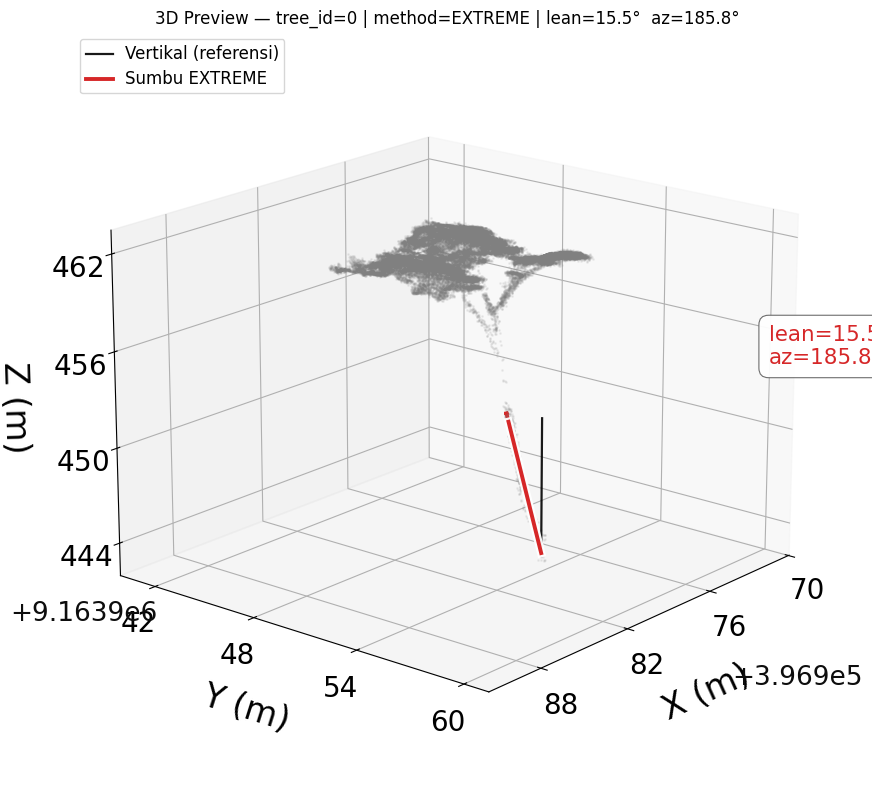

3D preview: /content/drive/MyDrive/Stemlean/Output/previews/98_sim3d_tree0_EXTREME.png


In [32]:
# =========================
# 3D PREVIEW — anti-tertutup + anti-tumpuk tick
# Offset e-notation ditempatkan di level FIGURE (bisa digeser)
# Label hasil (lean & azimuth) bisa digeser (sepanjang / menyamping / naik)
# =========================
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- helper dasar ----------
def _vec_from_lean_az(lean_deg, az_deg):
    """Ubah (lean°, azimuth°) menjadi vektor 3D satuan; pastikan mengarah ke atas (vz>=0)."""
    th = np.radians(float(lean_deg))
    az = np.radians(float(az_deg))
    v = np.array([np.sin(th)*np.sin(az), np.sin(th)*np.cos(az), np.cos(th)], float)
    v = v / max(np.linalg.norm(v), 1e-9)
    if v[2] < 0: v = -v
    return v

def _set_axes_equal_3d(ax):
    """Skala X/Y/Z sama (proporsi kubus) agar panah tidak terdistorsi."""
    xl=ax.get_xlim3d(); yl=ax.get_ylim3d(); zl=ax.get_zlim3d()
    r=max(abs(xl[1]-xl[0]), abs(yl[1]-yl[0]), abs(zl[1]-zl[0]))
    ax.set_xlim3d(np.mean(xl)-r/2, np.mean(xl)+r/2)
    ax.set_ylim3d(np.mean(yl)-r/2, np.mean(yl)+r/2)
    ax.set_zlim3d(np.mean(zl)-r/2, np.mean(zl)+r/2)

def _pick_tree(method="TRUNK"):
    """Pilih tree_id dengan lean terbesar pada layer metode."""
    method = method.upper()
    gmap = {"TRUNK": gTR_pts, "EXTREME": gEX_pts, "BT": gBT_pts}
    g = gmap.get(method, gTR_pts)
    if len(g)==0:
        for k in ["TRUNK","EXTREME","BT"]:
            if len(gmap[k])>0:
                method, g = k, gmap[k]; break
    if len(g)==0:
        raise RuntimeError("Tidak ada hasil metode apa pun (TRUNK/EXTREME/BT).")
    row = g.sort_values("lean_deg", ascending=False).iloc[0]
    return int(row["tree_id"]), float(row["lean_deg"]), float(row["lean_az"]), method

def _orthonormals(v):
    """Bangun dua vektor ortonormal (n1,n2) yang tegak lurus sumbu v."""
    n1 = np.cross(v, np.array([0, 0, 1.0]))
    if np.linalg.norm(n1) < 1e-6:
        n1 = np.cross(v, np.array([0, 1.0, 0]))
    n1 = n1 / max(np.linalg.norm(n1), 1e-9)
    n2 = np.cross(v, n1)
    n2 = n2 / max(np.linalg.norm(n2), 1e-9)
    return n1, n2

# ---------- offset e-notation di level FIGURE (supaya tak nabrak label sumbu) ----------
def place_offsets_outside(ax, x_fig, y_fig, z_fig, fontsize=16, color="0.05"):
    """
    Ambil teks offset bawaan axis (mis. '+3.968e5') lalu gambar ulang di level FIGURE.
    Parameter x_fig, y_fig, z_fig: tuple (x,y) dalam koordinat figure (0..1).
    """
    fig = ax.figure
    fig.canvas.draw()  # hitung teks offset dulu

    x_str = ax.xaxis.get_offset_text().get_text()
    y_str = ax.yaxis.get_offset_text().get_text()
    z_str = ax.zaxis.get_offset_text().get_text()

    # sembunyikan offset bawaan (yang nempel ke axis)
    ax.xaxis.get_offset_text().set_visible(False)
    ax.yaxis.get_offset_text().set_visible(False)
    ax.zaxis.get_offset_text().set_visible(False)

    # gambar offset di figure
    if x_str: fig.text(x_fig[0], x_fig[1], x_str, fontsize=fontsize, color=color, ha="left", va="bottom")
    if y_str: fig.text(y_fig[0], y_fig[1], y_str, fontsize=fontsize, color=color, ha="left", va="bottom")
    if z_str: fig.text(z_fig[0], z_fig[1], z_str, fontsize=fontsize, color=color, ha="left", va="top")

# ---------- fungsi utama ----------
def preview_tree_3d(
    tid=None, method="TRUNK", max_points=60_000,
    point_size=1.0, point_alpha=0.10,       # transparansi titik
    tube_clear=True, tube_radius=0.25,      # kosongkan tabung kecil di sekitar sumbu
    view_elev=18, view_azim=40,             # sudut kamera

    # Posisi offset e-notation (KOORDINAT FIGURE 0..1)
    x_off_fig=(0.85, 0.12),
    y_off_fig=(0.12, 0.12),
    z_off_fig=(0.12, 0.92),
    offset_fs=16,

    # ==== KONTROL LABEL HASIL (lean & azimuth) ====
    # Tpos = P1 + (label_along*L)*v + (label_perp*L)*n1 + (label_up*L)*n2
    label_along=0.25,   # geser SEPANJANG panah dari ujung (fraksi L; + maju)
    label_perp=0.15,    # geser MENYAMPING (tegak-lurus panah; fraksi L)
    label_up=0.00,      # geser ke arah ortonormal kedua (fraksi L)
    label_fs=12,        # ukuran font label
    label_ha="left",    # anchor horizontal label: "left"/"center"/"right"
    label_va="bottom",  # anchor vertikal label: "bottom"/"center"/"top"
    label_pad=0.35,     # padding bbox label

    save=True, show=True
):
    # ambil hasil (lean, az) dari layer metode
    if tid is None:
        tid, lean_deg, az_deg, method = _pick_tree(method)
    else:
        method = method.upper()
        gmap = {"TRUNK": gTR_pts, "EXTREME": gEX_pts, "BT": gBT_pts}
        g = gmap[method]
        if len(g[g["tree_id"]==int(tid)])==0:
            for k in ["TRUNK","EXTREME","BT"]:
                if len(gmap[k][gmap[k]["tree_id"]==int(tid)])>0:
                    method, g = k, gmap[k]; break
        row = g[g["tree_id"]==int(tid)].iloc[0]
        lean_deg, az_deg = float(row["lean_deg"]), float(row["lean_az"])

    # subset point cloud satu pohon
    dfg = df[df["tree_id"]==int(tid)].copy()
    if len(dfg)>max_points: dfg = dfg.sample(max_points, random_state=1)
    X, Y, Z = dfg["X"].values, dfg["Y"].values, dfg["Z"].values
    H, HN  = dfg["HeightAboveGround"].values, dfg["HN"].values

    # pangkal panah = median 5% terbawah
    m_low = (HN <= 0.05)
    if m_low.sum() >= 5:
        P0 = np.median(np.c_[X[m_low], Y[m_low], Z[m_low]], axis=0)
    else:
        i0 = int(np.argmin(H)); P0 = np.array([X[i0], Y[i0], Z[i0]], float)

    # vektor sumbu & panjang panah
    v = _vec_from_lean_az(lean_deg, az_deg)
    L = 0.8 * max(1.0, float(np.percentile(H,99) - np.percentile(H,1)))
    P1 = P0 + L*v

    # kosongkan tabung sekitar sumbu agar panah & label tak tertutup titik
    Xm, Ym, Zm = X, Y, Z
    if tube_clear:
        PP = np.c_[X, Y, Z] - P0
        t  = PP @ v
        d  = np.linalg.norm(np.cross(PP, v), axis=1)
        mask = ~((t>=0) & (t<=L) & (d<=tube_radius))
        Xm, Ym, Zm = X[mask], Y[mask], Z[mask]

    # --- plot ---
    fig = plt.figure(figsize=(9.5, 8))
    ax  = fig.add_subplot(111, projection="3d")
    ax.view_init(elev=view_elev, azim=view_azim)

    # label & tick anti-tumpuk
    LABEL_FS, TICK_FS, TITLE_FS = 24, 20, 12
    ax.set_xlabel("X (m)", fontsize=LABEL_FS, labelpad=23)
    ax.set_ylabel("Y (m)", fontsize=LABEL_FS, labelpad=23)
    ax.set_zlabel("Z (m)", fontsize=LABEL_FS, labelpad=20)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    ax.zaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    ax.tick_params(axis='x', which='major', labelsize=TICK_FS, pad=6)
    ax.tick_params(axis='y', which='major', labelsize=TICK_FS, pad=6)
    ax.tick_params(axis='z', which='major', labelsize=TICK_FS, pad=6)

    # format angka: offset e-notation utk X & Y, Z tanpa offset
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=True,  useMathText=False))
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=True,  useMathText=False))
    ax.zaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))

    # titik sangat transparan
    ax.scatter(Xm, Ym, Zm, s=point_size, alpha=point_alpha, c="0.5",
               depthshade=False, zorder=1)

    # garis vertikal referensi
    ax.plot([P0[0], P0[0]], [P0[1], P0[1]], [P0[2], P0[2]+L],
            color="k", linewidth=1.6, zorder=5, alpha=0.9, label="Vertikal (referensi)")

    # panah utama (outline putih + batang merah + kepala panah)
    Lhead  = min(0.6, 0.25*L)
    Pshaft = P0 + (L-Lhead)*v
    ax.plot([P0[0], Pshaft[0]], [P0[1], Pshaft[1]], [P0[2], Pshaft[2]],
            color="white", linewidth=6.0, zorder=8, alpha=0.95)
    ax.plot([P0[0], Pshaft[0]], [P0[1], Pshaft[1]], [P0[2], Pshaft[2]],
            color="tab:red", linewidth=2.8, zorder=9, label=f"Sumbu {method}")
    ax.quiver(Pshaft[0], Pshaft[1], Pshaft[2], Lhead*v[0], Lhead*v[1], Lhead*v[2],
              arrow_length_ratio=0.35, linewidth=2.8, color="tab:red", zorder=10)

    # ===== label hasil: posisikan via (label_along, label_perp, label_up) =====
    n1, n2 = _orthonormals(v)
    Tpos = P1 + (label_along * L) * v + (label_perp * L) * n1 + (label_up * L) * n2
    ax.text(
        Tpos[0], Tpos[1], Tpos[2],
        f"lean={lean_deg:.1f}°\naz={az_deg:.1f}°",
        fontsize=label_fs, color="tab:red", ha=label_ha, va=label_va,
        bbox=dict(boxstyle=f"round,pad={label_pad}", fc="white", ec="0.4", lw=0.8, alpha=0.95),
        zorder=12, clip_on=False
    )

    ax.set_title(f"3D Preview — tree_id={tid} | method={method} | "
                 f"lean={lean_deg:.1f}°  az={az_deg:.1f}°", fontsize=TITLE_FS)
    leg = ax.legend(loc="upper left", frameon=True)
    for t in leg.get_texts(): t.set_fontsize(12)

    _set_axes_equal_3d(ax)
    plt.tight_layout()

    # tempatkan offset e-notation di figure (tidak nabrak label X/Y/Z)
    place_offsets_outside(ax, x_off_fig, y_off_fig, z_off_fig, fontsize=offset_fs, color="0.05")

    # simpan / tampilkan
    out_dir = PREV_DIR if 'PREV_DIR' in globals() else "."
    out = os.path.join(out_dir, f"98_sim3d_tree{tid}_{method}.png")
    if save: plt.savefig(out, dpi=260)
    if show: plt.show()
    else: plt.close()
    print("3D preview:", out)

# ====== CONTOH PAKAI (silakan ubah) ======
preview_tree_3d(
    tid=0, method="EXTREME",
    # geser offset supaya tak nabrak label sumbu:
    x_off_fig=(0.80, 0.13),  # geser offset X nilai keci kiri/turun
                y_off_fig=(0.04, 0.21),  # geser offset Y
                z_off_fig=(0.10, 0.93),  # geser offset Z
                offset_fs=19,
    # atur posisi label hasil:
    label_along=0.05,  # makin besar → label makin maju ke depan sepanjang panah
    label_perp=1.00,   # makin besar → label makin ke samping
    label_up=-1.00,     # naikkan/dTurunkan ke arah ortonormal kedua
    label_fs=15.4, label_ha="left", label_va="bottom", label_pad=0.45
)
